<a href="https://colab.research.google.com/github/tuhuayuan/edhec_mooc2/blob/master/lab_202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Clone or Update the mooc repo.
%cd /content
!git -C edhec_mooc2 pull || git clone -l -s https://github.com/tuhuayuan/edhec_mooc2.git edhec_mooc2
%cd /content/edhec_mooc2

/content
Already up to date.
/content/edhec_mooc2


# Sharpe Style Analysis

Sharpe Style Analysis is an elegant and simple decomposition exercise similar to what we did in the previous lab session, with the added constraint that the coefficients are all positive and add to 1.

Therefore, the coefficients of performing style analysis on the observed return of a manager can be interpreted as weights in a portfolio of building blocks which together, _mimic_ that return series. The exercise can reveal drifts in a manager's style as well as provide insight into what the manager is likely doing to obtain the returns.


# Performing Sharpe Style Analysis

The key to obtaining the weights is our old friend, the quadriatic optimizer. We are asking the optimizer to find the weights that minimizes the square of the difference between the observed series and the returns of a benchmark portfolio that holds the explanatory building blocks in those same weights. This is equivalent to minimizing the _tracking error_ between the two return series.

The code to implement this is a very slight modification of the `minimize_vol` we have previously implemented:

```python                         
def style_analysis(dependent_variable, explanatory_variables):
    """
    Returns the optimal weights that minimizes the Tracking error between
    a portfolio of the explanatory variables and the dependent variable
    """
    n = explanatory_variables.shape[1]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    solution = minimize(portfolio_tracking_error, init_guess,
                       args=(dependent_variable, explanatory_variables,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    weights = pd.Series(solution.x, index=explanatory_variables.columns)
    return weights
```

The Objective function is a very simple one-liner

```python
def portfolio_tracking_error(weights, ref_r, bb_r):
    """
    returns the tracking error between the reference returns
    and a portfolio of building block returns held with given weights
    """
    return tracking_error(ref_r, (weights*bb_r).sum(axis=1))
```

In [ ]:
import numpy as np
import pandas as pd

import edhec_risk_kit_202 as erk

%load_ext autoreload
%autoreload 2


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
ind = erk.get_ind_returns()["2000":]

Let's construct a manager that invests in 30% Beer, 50% in Smoke and 20% in other things that have an average return of 0% and an annualized vol of 15%

In [ ]:
mgr_r = 0.3*ind["Beer"] + .5*ind["Smoke"] + 0.2*np.random.normal(scale=0.15/(12**.5), size=ind.shape[0])

Now, assume we knew absolutely nothing about this manager and all we observed was the returns. How could we tell what she was invested in?

In [ ]:
weights = erk.style_analysis(mgr_r, ind)*100

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


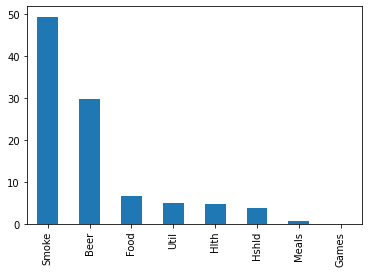

In [ ]:
weights.sort_values(ascending=False).head(8).plot.bar()

Contrast this to the results of a regression. Because the model is in fact very true (i.e. we really did construct the manager's returns out of the building blocks), the results are remarkably accurate. However, the negative coefficients are hard to intepret and in real-life data, those will be much larger. However when it works well, such as in this artificial example here, the results can be very accurate.

In [ ]:
m = erk.regress(mgr_r, ind)
coeffs = m.params*100
coeffs.sort_values().head()

FabPr   -4.197333
Trans   -2.795083
Rtail   -2.466207
Util    -1.934470
Food    -1.816017
dtype: float64

In [ ]:
m.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.956     
Dependent Variable: y                AIC:                -1508.0411
Date:               2021-03-20 14:11 BIC:                -1401.7313
No. Observations:   228              Log-Likelihood:     785.02    
Df Model:           30               F-statistic:        165.6     
Df Residuals:       197              Prob (F-statistic): 2.76e-123 
R-squared:          0.962            Scale:              6.9244e-05
----------------------------------------------------------------------
          Coef.     Std.Err.       t       P>|t|      [0.025    0.975]
----------------------------------------------------------------------
Food     -0.0182      0.0300    -0.6055    0.5456    -0.0773    0.0410
Beer      0.2904      0.0218    13.3223    0.0000     0.2474    0.3334
Smoke     0.5050      0.0113    44.6817    0.0000     0.4827    0.5273
Games    -0.0109      0.0159    -0.6848    0.4943    -0.0423    0.0205
Books     0.0102      0.0200     0.5087    0.6115    -0.0293    0.0496
Hshld    -0.0164      0.0237    -0.6917    0.4900    -0.0631    0.0303
Clths     0.0009      0.0182     0.0487    0.9612    -0.0349    0.0367
Hlth      0.0002      0.0227     0.0080    0.9936    -0.0446    0.0449
Chems     0.0315      0.0250     1.2592    0.2094    -0.0178    0.0808
Txtls     0.0021      0.0120     0.1715    0.8640    -0.0217    0.0258
Cnstr     0.0120      0.0217     0.5511    0.5822    -0.0308    0.0547
Steel    -0.0042      0.0152    -0.2778    0.7814    -0.0342    0.0258
FabPr    -0.0420      0.0284    -1.4775    0.1412    -0.0980    0.0141
ElcEq     0.0363      0.0243     1.4910    0.1376    -0.0117    0.0843
Autos    -0.0012      0.0135    -0.0885    0.9296    -0.0278    0.0254
Carry     0.0253      0.0175     1.4468    0.1495    -0.0092    0.0599
Mines    -0.0032      0.0116    -0.2778    0.7815    -0.0262    0.0197
Coal      0.0068      0.0064     1.0556    0.2924    -0.0059    0.0194
Oil      -0.0152      0.0172    -0.8847    0.3774    -0.0491    0.0187
Util     -0.0193      0.0195    -0.9932    0.3218    -0.0578    0.0191
Telcm    -0.0068      0.0197    -0.3440    0.7312    -0.0455    0.0320
Servs    -0.0025      0.0231    -0.1087    0.9135    -0.0481    0.0430
BusEq     0.0032      0.0178     0.1769    0.8598    -0.0320    0.0383
Paper    -0.0178      0.0300    -0.5931    0.5538    -0.0770    0.0414
Trans    -0.0280      0.0223    -1.2509    0.2125    -0.0720    0.0161
Whlsl     0.0238      0.0249     0.9538    0.3414    -0.0254    0.0729
Rtail    -0.0247      0.0255    -0.9672    0.3346    -0.0749    0.0256
Meals     0.0193      0.0242     0.7980    0.4259    -0.0284    0.0671
Fin      -0.0103      0.0214    -0.4807    0.6312    -0.0526    0.0320
Other     0.0074      0.0188     0.3906    0.6965    -0.0298    0.0445
Alpha     0.0007      0.0006     1.1985    0.2322    -0.0005    0.0019
-------------------------------------------------------------------
Omnibus:               0.358         Durbin-Watson:           1.947
Prob(Omnibus):         0.836         Jarque-Bera (JB):        0.456
Skew:                  -0.088        Prob(JB):                0.796
Kurtosis:              2.868         Condition No.:           69   
===================================================================

"""

Negative 4.5% in Household?

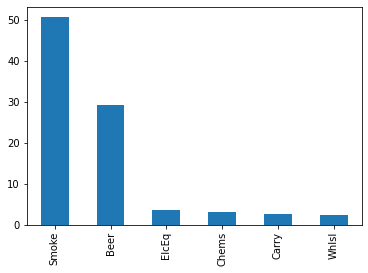

In [ ]:
coeffs.sort_values(ascending=False).head(6).plot.bar()

## Style Drift: Time Varying Exposures using Style Anaylsis

One of the most common ways in which Sharpe Style Analysis can be used is to measure style drift. If you run the style analysis function over a rolling window of 1 to 5 years, you can extract changes in the style exposures of a manager.

We'll look at Rolling Windows in the next lab session.

As an exercise to the student, download a set of returns from Yahoo Finance, and try and measure the style drift in your favorite fund manager. Use reliable Value and Growth ETFs such as "SPYG" and "SPYV" along with a SmallCap ETF such as "SLY" and LargeCap ETF such as "OEF".

Alternately, the Fama-French research factors and use the Top and Bottom portfolios by Value (HML) and Size (SMB) to categorize mutual funds into categories. This is very similar to the "Style Box" methodology employed by Morningstar and displayed on their website. Compare your results with their results to see if they agree!

In [ ]:
!pip install -q akshare

# A股数据分析

- 选取沪深300作为目标指数，申万一级行业指数作为解释变量分析风格
- 用A股法玛三因子数据分析公募基金风格
- 沪深300ETF的追踪误差

In [ ]:
%reload_ext google.colab.data_table

import akshare as ak
import datetime as dt

In [ ]:
def get_sh300_returns():
    """
    获取沪深300指数历史月收益数据2005年1月开始到当前日期
    """
    sh300 = ak.stock_zh_index_daily_em('sh000300')
    sh300_rets = sh300.set_index('date')['close']
    sh300_rets.index = pd.to_datetime(sh300_rets.index, format='%Y-%m-%d')
    sh300_rets = sh300_rets.pct_change().dropna()
    sh300_rets = sh300_rets.resample('M').apply(erk.compound).to_period('M')
    return sh300_rets

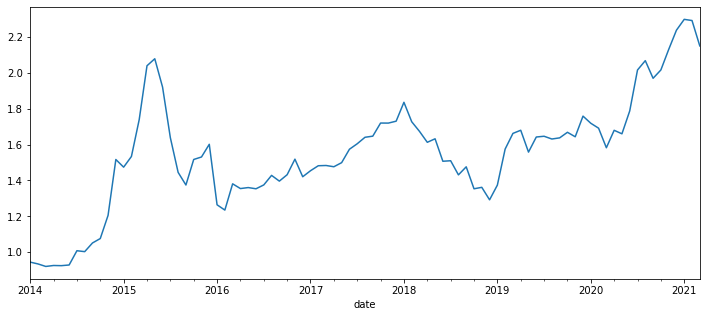

In [ ]:
sh300_rets = get_sh300_returns().loc["2014":]
(sh300_rets + 1).cumprod().plot(figsize=(12, 5))

In [ ]:
def get_swl1_returns(start_date='2014-01-01', end_date=None):
    """
    获取申万以及行业指数月收益
    """
    if not end_date:
        end_date = dt.date.today()

    def get_ind_history(code):
        """获取指数历史收益"""
        ind_rets = ak.sw_index_daily_indicator(index_code=code, 
                                               start_date=start_date, 
                                               end_date=end_date, 
                                               data_type="Week")
        ind_rets = pd.to_numeric(ind_rets.set_index('date')['close'])
        ind_rets = ind_rets.sort_index()
        ind_rets = ind_rets.pct_change().dropna()
        ind_rets = ind_rets.resample('M').apply(erk.compound).to_period('M')
        return ind_rets
        
    swl1_index = ak.sw_index_spot()
    rets = swl1_index['指数代码'].apply(lambda code: get_ind_history(code))
    rets = rets.T
    rets.columns = swl1_index['指数名称'].to_list()
    return rets

In [ ]:
rets = get_swl1_returns(start_date='2014-01-01')

In [ ]:
!pip install -q pyplotz

In [ ]:
from pyplotz.pyplotz import PyplotZ
pltz = PyplotZ()
pltz.enable_chinese()

try downloading
start downloading default chinese font(only for first time)
downloading complete
Font installed at the first time


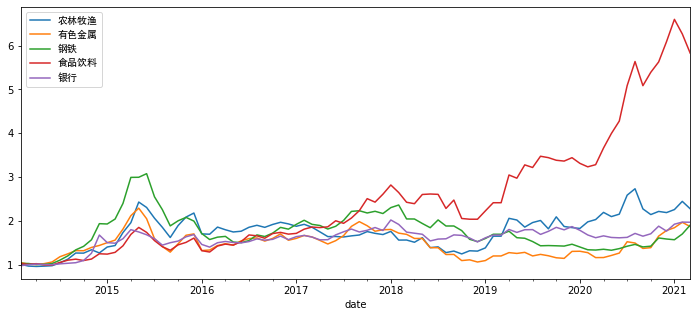

In [ ]:
ax = (rets.dropna()[['农林牧渔', '有色金属', '钢铁', '食品饮料', '银行']] + 1).cumprod().plot(figsize=(12, 5))
pltz.legend()
pltz.show()

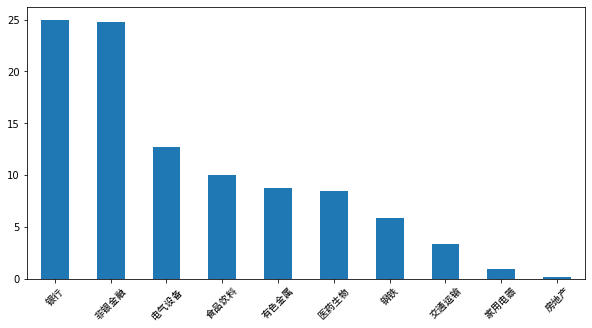

In [ ]:
weights_b = erk.style_analysis(sh300_rets, rets)
(weights_b.sort_values(ascending=False).head(10).round(4)*100).plot.bar(figsize=(10, 5))
pltz.xticks(rotation=45)

In [ ]:
def get_cn_fff_returns():
    """
    获取中国证券市场3因数模型
    """
    cn_fff = pd.read_csv('data/factor_monthly/fivefactor_monthly.csv',
                         header=0, index_col=0)
    cn_fff.index = pd.to_datetime(cn_fff.index, format='%Y%m').to_period('M')
    return cn_fff[['mkt_rf', 'smb', 'hml', 'rf']]

In [ ]:
cn_fff = get_cn_fff_returns()['2014':]
m = erk.regress((sh300_rets - cn_fff['rf']), cn_fff[['mkt_rf', 'hml', 'smb']])
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     359.2
Date:                Sat, 20 Mar 2021   Prob (F-statistic):           2.02e-47
Time:                        14:14:22   Log-Likelihood:                 227.39
No. Observations:                  87   AIC:                            -446.8
Df Residuals:                      83   BIC:                            -436.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
mkt_rf         0.9699      0.030     32.694      0.000       0.911       1.029
hml            0.2383      0.051      4.693      0.000       0.137       0.339
smb           -0.4087      0.050     -8.146      0.000      -0.509      -0.309
Alpha          0.0014      0.002      0.732      0.466      -0.002       0.005
==============================================================================
Omnibus:                        9.495   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               13.448
Skew:                           0.459   Prob(JB):                      0.00120
Kurtosis:                       4.693   Cond. No.                         31.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
def get_fund_returns(fund):
    """
    获取公募基金净值回报率
    """
    fund_rets = ak.fund_em_etf_fund_info(fund=fund)
    fund_rets['date'] = pd.to_datetime(fund_rets['净值日期'])
    fund_rets['return'] = pd.to_numeric(fund_rets['日增长率']) / 100
    fund_rets = fund_rets.dropna()
    fund_rets = fund_rets.set_index('date')
    fund_rets = fund_rets['return'] 
    return fund_rets.resample('M').apply(erk.compound).to_period('M')


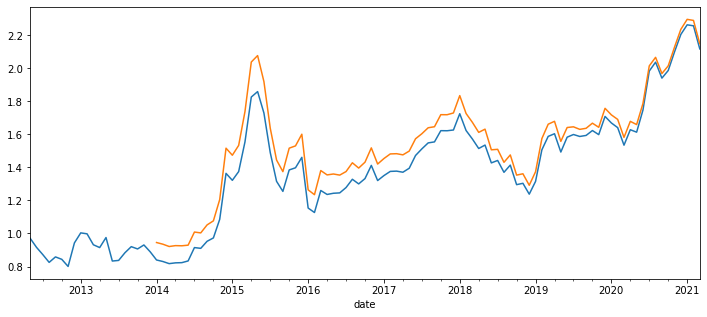

In [ ]:
fund_300etf_rets = get_fund_returns('510300')
ax = (fund_300etf_rets + 1).cumprod().plot(figsize=(12, 5))
(sh300_rets + 1).cumprod().plot(ax=ax)

In [ ]:
(fund_300etf_rets - sh300_rets).dropna().std()

0.003173310323343319

# Warning: Potential Misuse of Style Analysis

Style Analysis works best when the explanatory indices are in fact a good specification of what is happening. For instance, it usually gives you very useful and revealing insight if you use a stock market index (such as SPY) and other broad indices, ETFs or mutual funds (such as a Value Fund, a Growth Fund, an International Fund, a Bond Fund etc).

Part of the skill in extracting meaningful results is to pick the right set of explanatory variables.

However, a part of the challenge with Style Analysis is that it will _always_ return a portfolio. Although it is possible to develop a figure of merit of fit quality similar to an $R^2$, it will still always give you an answer, however unreasonable it might be, and it's not always obvious how much one can rely on the result.

For instance, we can try and extract the major industries that Buffer invested in since 2000 as follows:

In [ ]:
brka_d = pd.read_csv("data/brka_d_ret.csv", parse_dates=True, index_col=0)
brka_m = brka_d.resample('M').apply(erk.compound).to_period('M')
brka_m.head()

,BRKA
DATE,
1990-01,-0.140634
1990-02,-0.030852
1990-03,-0.069204
1990-04,-0.003717
1990-05,0.067164


In [ ]:
mgr_r_b = brka_m["2000":]["BRKA"]
weights_b = erk.style_analysis(mgr_r_b, ind)
weights_b.sort_values(ascending=False).head(6).round(4)*100

Food     41.35
Fin      17.61
Meals    12.11
Other    11.03
Util      7.19
Clths     5.99
dtype: float64

If we want to look at the last decade (2009-2018):

In [ ]:
brk2009 = brka_m["2009":]["BRKA"]
ind2009 = ind["2009":]
erk.style_analysis(brk2009, ind2009).sort_values(ascending=False).head(6).round(4)*100

Other    43.64
Food     28.33
Hlth     22.72
Rtail     5.25
Meals     0.07
Fin       0.00
dtype: float64

Should you believe the analysis? Probably not. However, when the specification is in fact accurate (as we saw in the articially generated series) the results can be very revealing